In [1]:
# !pip install tensorflow_probability


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import pickle
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import RobustScaler
os.sys.path.append('../../../evaluation/')
import metrics


In [15]:
# training parameters
n_dimensions = 2
epochs = 100
batch_size = 16
n_bins_input = 100 # number of bins in input histogram images
n_bins_output = 20 # number of bins in output probability density images
grid_edge = 3 # range of images
loss = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0)
# opt = tf.keras.optimizers.Adam()
input_path = '../../../data/simulated_2d/'
output_path = './model/'
from predict import extract_features


In [4]:
# load data
x_train = pickle.load(open(input_path+'/train/input_data.pkl', 'rb'))
data_train = pickle.load(open(input_path+'/train/input_data.pkl', 'rb'))
y_train = pickle.load(open(input_path+'/train/target_data.pkl', 'rb'))
y_train = [
    metrics.output_to_stats_2d(i) for i in y_train
]

x_val = pickle.load(open(input_path+'/val/input_data.pkl', 'rb'))
y_val = pickle.load(open(input_path+'/val/target_data.pkl', 'rb'))
y_val = [
    metrics.output_to_stats_2d(i) for i in y_val
]


In [5]:
def extract_features(data):
    '''
    Function for extracting features from 2d inputs
    
    Arguments:
        data:      2D numpy array (samples, features)
    Returns:
        features:  feature vector
    '''
    
    # ensure correct shape
    data = data.squeeze()
    assert data.shape[1]==2, 'Error: input data is not 2D'
    
    # check for standardized data
    assert all([np.abs(0-i)<1e-2 for i in data.mean(axis=0)]), 'Error: data not standardized'
    assert all([np.abs(1-i)<1e-2 for i in data.std(axis=0)]), 'Error: data not standardized'
    
    # extract features
    fgridrng = (-grid_edge, grid_edge)
    fgridpts = n_bins_input
    features = np.histogram2d(data[:,0], data[:,1], np.linspace(fgridrng[0], fgridrng[1], fgridpts+1), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    
    return features


In [6]:
# x_train = x_train[:1000]
# y_train = y_train[:1000]


In [7]:
# extract features
x_train = [extract_features(i) for i in x_train]
x_train = np.array(x_train).squeeze()
x_val = [extract_features(i) for i in x_val]
x_val = np.array(x_val).squeeze()
x_train = x_train[..., np.newaxis]
x_val = x_val[..., np.newaxis]


In [8]:
def get_grid_positions(n_dimensions, n_bins_output):
    """ Gets an array of grid positions in N-D space for computing probability densities
    """
    grids = []
    for i in range(n_dimensions):
        grids.append(np.linspace(-grid_edge, grid_edge, n_bins_output))
    grids = np.meshgrid(*grids)
    positions = np.vstack([i.ravel() for i in grids]).T
    return positions
# test
# test = get_grid_positions(2, 20)
# plt.scatter(test[:,0], test[:,1])

target_grid = get_grid_positions(n_dimensions, n_bins_output)

def get_target_density(target_vector, grid):
    gs = multivariate_normal(target_vector[0], target_vector[1])
    densities = gs.pdf(target_grid)
    densities = densities.reshape((n_bins_output,)*n_dimensions)
    return densities.T[..., np.newaxis]

# # test
# data_val = pickle.load(open(input_path+'/val/input_data.pkl', 'rb')) # get original data samples
# idx = np.random.choice(len(x_val))
# test = get_target_density(y_val[idx], target_grid)
# plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plt.scatter(data_val[idx][:,0], data_val[idx][:,1], s=5, alpha=0.1)
# plt.xlim([-grid_edge, grid_edge]), plt.ylim([-grid_edge, grid_edge])
# plt.gca().add_patch(metrics.plot_cov_ellipse(y_val[idx][0], y_val[idx][1], fc='none', color='r'))
# plt.subplot(1,3,2)
# plt.pcolormesh(np.linspace(-grid_edge, grid_edge, n_bins_output), np.linspace(-grid_edge, grid_edge, n_bins_output), x_val[idx].squeeze().T)
# plt.gca().add_patch(metrics.plot_cov_ellipse(y_val[idx][0], y_val[idx][1], fc='none', color='r'))
# plt.subplot(1,3,3)
# plt.pcolormesh(np.linspace(-grid_edge, grid_edge, n_bins_output), np.linspace(-grid_edge, grid_edge, n_bins_output), test.T.squeeze())
# plt.gca().add_patch(metrics.plot_cov_ellipse(y_val[idx][0], y_val[idx][1], fc='none', color='r'))


In [9]:
# convert targets to probability density images
y_train = [get_target_density(i, target_grid) for i in y_train]
y_train = np.array([(i-i.min())/(i.max()-i.min()) for i in y_train]) # normalize
y_val = [get_target_density(i, target_grid) for i in y_val]
y_val = np.array([(i-i.min())/(i.max()-i.min()) for i in y_val])


In [10]:
# nr = 8
# c = 0
# plt.figure(figsize=(nr*1, nr*(1*3)))
# for i in range(0, nr*3, 3):
    
#     idx = np.random.choice(len(x_train))
    
#     plt.subplot(nr, 3, i+1)
#     plt.scatter(data_train[idx][:,0], data_train[idx][:,1], alpha=0.1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.xlim([-grid_edge, grid_edge])
#     plt.ylim([-grid_edge, grid_edge])
    
#     plt.subplot(nr, 3, i+2)
#     plt.pcolormesh(x_train[idx].T.squeeze())
#     plt.xticks([])
#     plt.yticks([])
    
#     plt.subplot(nr, 3, i+3)
#     plt.pcolormesh(y_train[idx].T.squeeze())
#     plt.xticks([])
#     plt.yticks([])
    
# plt.tight_layout()


In [16]:
def create_encoder_decoder(input_shape, output_shape):
    """
    Creates an encoder-decoder model with separate input and output shapes.
    
    Parameters:
    input_shape (tuple): Shape of the input image, e.g., (height, width, channels).
    output_shape (tuple): Shape of the output image, e.g., (height, width, channels).
    
    Returns:
    model (tf.keras.Model): A compiled Keras model for the encoder-decoder network.
    """
    
    kernel_size = 10
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, kernel_size, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, kernel_size, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = layers.Conv2D(128, kernel_size, activation='relu', padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(64, kernel_size, strides=2, activation='relu', padding='same')(encoded)
    x = layers.Conv2DTranspose(32, kernel_size, strides=2, activation='relu', padding='same')(x)
    
    # Adjusting output to match the specified output shape
    output_channels = output_shape[2]
    decoded = layers.Conv2D(output_channels, kernel_size, activation='sigmoid', padding='same')(x)

    # Reshape the output to match the desired output shape
    output_resized = tf.image.resize(decoded, size=(output_shape[0], output_shape[1]))

    # Define the model
    model = models.Model(inputs, output_resized)
    
    # Compile the model
    model.compile(optimizer=opt, loss=loss)

    return model

# Example usage
input_shape = (n_bins_input, n_bins_input, 1)   # Example input shape
output_shape = (n_bins_output, n_bins_output, 1)   # Example output shape
model = create_encoder_decoder(input_shape, output_shape)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      3232      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 64)        204864    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 25, 25, 128)       8193

In [17]:
# image_shape = (n_bins_input, n_bins_input, 1)
# class Denoise(Model):
#     def __init__(self):
#         super(Denoise, self).__init__()
#         self.encoder = tf.keras.Sequential([
#             layers.Input(shape=image_shape),
#             layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
#             layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

#         self.decoder = tf.keras.Sequential([
#             layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
#             layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
#             layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

#     def call(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

# model = Denoise()
# model.compile(optimizer=opt, loss=loss)
# test = model(x_val)
# model.summary()


In [18]:
# plot model

# !pip install pydot
# !pip install graphviz

# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=False,
# )


In [ ]:
# define best model checkpoint
checkpoint_path = output_path+'/model_checkpoint'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_format='tf',
    verbose=1
)

# train
history = model.fit(
    x_train, 
    y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [checkpoint_callback],
)

with open(output_path+'/model_history.npy', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    

Epoch 1/100


I0000 00:00:1722422567.014172    6489 service.cc:145] XLA service 0x7efb355221d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722422567.014218    6489 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1722422567.045550    6489 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


813/813 [==============================] - ETA: 0s - loss: 0.0729
Epoch 1: val_loss improved from inf to 0.04930, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 21s 21ms/step - loss: 0.0729 - val_loss: 0.0493
Epoch 2/100
813/813 [==============================] - ETA: 0s - loss: 0.0216
Epoch 2: val_loss improved from 0.04930 to 0.01246, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 14s 17ms/step - loss: 0.0216 - val_loss: 0.0125
Epoch 3/100
813/813 [==============================] - ETA: 0s - loss: 0.0109
Epoch 3: val_loss improved from 0.01246 to 0.00997, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 17ms/step - loss: 0.0109 - val_loss: 0.0100
Epoch 4/100
813/813 [==============================] - ETA: 0s - loss: 0.0095
Epoch 4: val_loss improved from 0.00997 to 0.00896, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 5/100
813/813 [==============================] - ETA: 0s - loss: 0.0086
Epoch 5: val_loss improved from 0.00896 to 0.00810, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 6/100
813/813 [==============================] - ETA: 0s - loss: 0.0079
Epoch 6: val_loss improved from 0.00810 to 0.00765, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 14s 17ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 7/100
813/813 [==============================] - ETA: 0s - loss: 0.0074
Epoch 7: val_loss did not improve from 0.00765
813/813 [==============================] - 12s 15ms/step - loss: 0.0074 - val_loss: 0.0082
Epoch 8/100
813/813 [==============================] - ETA: 0s - loss: 0.0071
Epoch 8: val_loss improved from 0.00765 to 0.00759, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0071 - val_loss: 0.0076
Epoch 9/100
813/813 [==============================] - ETA: 0s - loss: 0.0069
Epoch 9: val_loss improved from 0.00759 to 0.00696, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 17ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 10/100
813/813 [==============================] - ETA: 0s - loss: 0.0067
Epoch 10: val_loss improved from 0.00696 to 0.00671, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 11/100
813/813 [==============================] - ETA: 0s - loss: 0.0066
Epoch 11: val_loss improved from 0.00671 to 0.00647, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 14s 17ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 12/100
813/813 [==============================] - ETA: 0s - loss: 0.0065
Epoch 12: val_loss improved from 0.00647 to 0.00629, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 13/100
813/813 [==============================] - ETA: 0s - loss: 0.0064
Epoch 13: val_loss improved from 0.00629 to 0.00620, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 14/100
811/813 [============================>.] - ETA: 0s - loss: 0.0063
Epoch 14: val_loss improved from 0.00620 to 0.00614, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 15/100
813/813 [==============================] - ETA: 0s - loss: 0.0062
Epoch 15: val_loss improved from 0.00614 to 0.00613, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 16/100
813/813 [==============================] - ETA: 0s - loss: 0.0061
Epoch 16: val_loss improved from 0.00613 to 0.00599, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 17ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 17/100
813/813 [==============================] - ETA: 0s - loss: 0.0061
Epoch 17: val_loss improved from 0.00599 to 0.00592, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 14s 17ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 18/100
813/813 [==============================] - ETA: 0s - loss: 0.0060
Epoch 18: val_loss improved from 0.00592 to 0.00589, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 19/100
813/813 [==============================] - ETA: 0s - loss: 0.0060
Epoch 19: val_loss did not improve from 0.00589
813/813 [==============================] - 12s 15ms/step - loss: 0.0060 - val_loss: 0.0063
Epoch 20/100
813/813 [==============================] - ETA: 0s - loss: 0.0059
Epoch 20: val_loss improved from 0.00589 to 0.00581, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 21/100
813/813 [==============================] - ETA: 0s - loss: 0.0058
Epoch 21: val_loss improved from 0.00581 to 0.00574, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 14s 17ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 22/100
813/813 [==============================] - ETA: 0s - loss: 0.0058
Epoch 22: val_loss did not improve from 0.00574
813/813 [==============================] - 12s 15ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 23/100
813/813 [==============================] - ETA: 0s - loss: 0.0057
Epoch 23: val_loss improved from 0.00574 to 0.00569, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 14s 17ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 24/100
813/813 [==============================] - ETA: 0s - loss: 0.0057
Epoch 24: val_loss did not improve from 0.00569
813/813 [==============================] - 12s 15ms/step - loss: 0.0057 - val_loss: 0.0069
Epoch 25/100
813/813 [==============================] - ETA: 0s - loss: 0.0056
Epoch 25: val_loss improved from 0.00569 to 0.00541, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 26/100
813/813 [==============================] - ETA: 0s - loss: 0.0056
Epoch 26: val_loss did not improve from 0.00541
813/813 [==============================] - 12s 15ms/step - loss: 0.0056 - val_loss: 0.0067
Epoch 27/100
813/813 [==============================] - ETA: 0s - loss: 0.0055
Epoch 27: val_loss did not improve from 0.00541
813/813 [==============================] - 12s 15ms/step - loss: 0.0055 - val_loss: 0.0072
Epoch 28/100
813/813 [==============================] - ETA: 0s - loss: 0.0055
Epoch 28: val_loss improved from 0.00541 to 0.00538, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 29/100
813/813 [==============================] - ETA: 0s - loss: 0.0055
Epoch 29: val_loss improved from 0.00538 to 0.00533, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 30/100
813/813 [==============================] - ETA: 0s - loss: 0.0054
Epoch 30: val_loss improved from 0.00533 to 0.00520, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 31/100
813/813 [==============================] - ETA: 0s - loss: 0.0054
Epoch 31: val_loss did not improve from 0.00520
813/813 [==============================] - 13s 15ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 32/100
813/813 [==============================] - ETA: 0s - loss: 0.0053
Epoch 32: val_loss did not improve from 0.00520
813/813 [==============================] - 12s 15ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 33/100
813/813 [==============================] - ETA: 0s - loss: 0.0053
Epoch 33: val_loss did not improve from 0.00520
813/813 [==============================] - 12s 15ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 34/100
813/813 [==============================] - ETA: 0s - loss: 0.0053
Epoch 34: val_loss did not improve from 0.00520
813/813 [==============================] - 12s 15ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 35/100
813/813 [===============

INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 37/100
813/813 [==============================] - ETA: 0s - loss: 0.0052
Epoch 37: val_loss improved from 0.00518 to 0.00498, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 38/100
813/813 [==============================] - ETA: 0s - loss: 0.0052
Epoch 38: val_loss did not improve from 0.00498
813/813 [==============================] - 12s 15ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 39/100
813/813 [==============================] - ETA: 0s - loss: 0.0051
Epoch 39: val_loss did not improve from 0.00498
813/813 [==============================] - 12s 15ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 40/100
813/813 [==============================] - ETA: 0s - loss: 0.0051
Epoch 40: val_loss improved from 0.00498 to 0.00497, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 14s 17ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 41/100
813/813 [==============================] - ETA: 0s - loss: 0.0051
Epoch 41: val_loss did not improve from 0.00497
813/813 [==============================] - 12s 15ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 42/100
811/813 [============================>.] - ETA: 0s - loss: 0.0050
Epoch 42: val_loss improved from 0.00497 to 0.00486, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 43/100
813/813 [==============================] - ETA: 0s - loss: 0.0050
Epoch 43: val_loss improved from 0.00486 to 0.00483, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 44/100
813/813 [==============================] - ETA: 0s - loss: 0.0043
Epoch 78: val_loss did not improve from 0.00422
813/813 [==============================] - 12s 15ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 79/100
813/813 [==============================] - ETA: 0s - loss: 0.0043
Epoch 79: val_loss improved from 0.00422 to 0.00417, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 80/100
813/813 [==============================] - ETA: 0s - loss: 0.0043
Epoch 80: val_loss improved from 0.00417 to 0.00411, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 81/100
813/813 [==============================] - ETA: 0s - loss: 0.0043
Epoch 81: val_loss did not improve from 0.00411
813/813 [==============================] - 12s 15ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 82/100
813/813 [==============================] - ETA: 0s - loss: 0.0043
Epoch 82: val_loss did not improve from 0.00411
813/813 [==============================] - 12s 15ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 83/100
813/813 [==============================] - ETA: 0s - loss: 0.0042
Epoch 83: val_loss did not improve from 0.00411
813/813 [==============================] - 13s 15ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 84/100
813/813 [==============================] - ETA: 0s - loss: 0.0042
Epoch 84: val_loss improved from 0.00411 to 0.00411, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 85/100
813/813 [==============================] - ETA: 0s - loss: 0.0042
Epoch 85: val_loss did not improve from 0.00411
813/813 [==============================] - 12s 15ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 86/100
813/813 [==============================] - ETA: 0s - loss: 0.0042
Epoch 86: val_loss did not improve from 0.00411
813/813 [==============================] - 13s 15ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 87/100
813/813 [==============================] - ETA: 0s - loss: 0.0042
Epoch 87: val_loss did not improve from 0.00411
813/813 [==============================] - 12s 15ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 88/100
813/813 [==============================] - ETA: 0s - loss: 0.0042
Epoch 88: val_loss did not improve from 0.00411
813/813 [==============================] - 12s 15ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 89/100
813/813 [===============

INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 95/100
813/813 [==============================] - ETA: 0s - loss: 0.0042
Epoch 95: val_loss did not improve from 0.00399
813/813 [==============================] - 12s 15ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 96/100
813/813 [==============================] - ETA: 0s - loss: 0.0041
Epoch 96: val_loss improved from 0.00399 to 0.00397, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 13s 16ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 97/100
813/813 [==============================] - ETA: 0s - loss: 0.0041
Epoch 97: val_loss did not improve from 0.00397
813/813 [==============================] - 12s 15ms/step - loss: 0.0041 - val_loss: 0.0052
Epoch 98/100
813/813 [==============================] - ETA: 0s - loss: 0.0041
Epoch 98: val_loss did not improve from 0.00397
813/813 [==============================] - 13s 15ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 99/100
811/813 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 99: val_loss did not improve from 0.00397
813/813 [==============================] - 13s 15ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 100/100
813/813 [==============================] - ETA: 0s - loss: 0.0041
Epoch 100: val_loss did not improve from 0.00397
813/813 [==============================] - 12s 15ms/step - loss: 0.0041 - val_loss: 0.0045


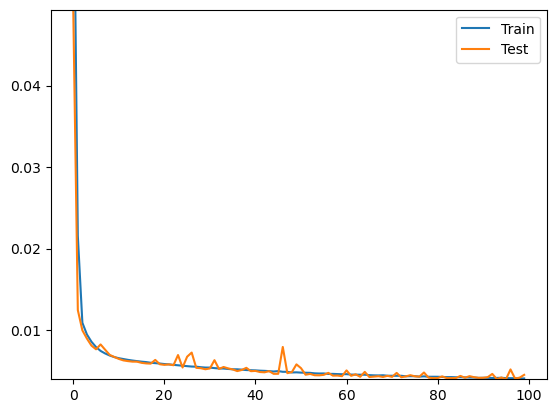

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.ylim([np.array(history.history['val_loss']).min(), np.array(history.history['val_loss']).max()])
plt.legend();


In [ ]:
p_val = model.predict(x_val)


32/32 [==============================] - 3s 59ms/step


In [35]:
data_val = pickle.load(open(input_path+'/val/input_data.pkl', 'rb')) # get original data samples


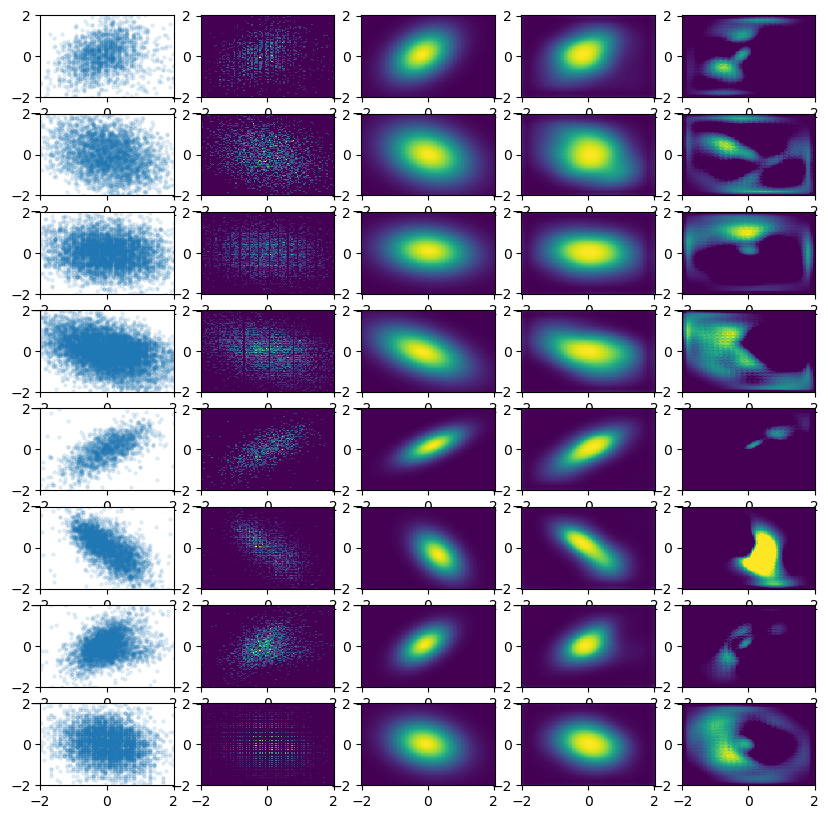

In [37]:
# test
nr = 8
plt.figure(figsize=(10, 10))
for i in range(0, nr*5, 5):
    idx = np.random.choice(len(x_val))
    plt.subplot(nr,5,i+1)
    plt.scatter(data_val[idx][:,0], data_val[idx][:,1], s=5, alpha=0.1)
    plt.xlim([-grid_edge, grid_edge]), plt.ylim([-grid_edge, grid_edge])
    plt.subplot(nr,5,i+2)
    plt.pcolormesh(np.linspace(-grid_edge, grid_edge, n_bins_output), np.linspace(-grid_edge, grid_edge, n_bins_output), x_val[idx].squeeze().T)
    plt.subplot(nr,5,i+3)
    plt.pcolormesh(np.linspace(-grid_edge, grid_edge, n_bins_output), np.linspace(-grid_edge, grid_edge, n_bins_output), y_val[idx].T.squeeze())
    plt.subplot(nr,5,i+4)
    plt.pcolormesh(np.linspace(-grid_edge, grid_edge, n_bins_output), np.linspace(-grid_edge, grid_edge, n_bins_output), p_val[idx].T.squeeze())
    plt.subplot(nr,5,i+5)
    plt.pcolormesh(np.linspace(-grid_edge, grid_edge, n_bins_output), np.linspace(-grid_edge, grid_edge, n_bins_output), (y_val[idx]-p_val[idx]).T.squeeze())
    plt.clim([0, 0.1])
    